In [1]:
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import sys, os
import django
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
import scoping.utils.learning_utils as lu
from scoping.models import *
from utils.text import *
import matplotlib
import re



In [200]:
df = pd.read_csv('../data/category_predictions.csv')
preds = [
    "2 - Trend or climate change attribtion - lower_pred",
    "6 - Precipitation - lower_pred",
    "6 - Temperature - lower_pred"
]
for c in preds:
    label = c.replace(" - lower_pred",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())

df = df.loc[
    (df['2 - Trend or climate change attribtion - lower_pred']>0.5) &
    (
        (df["6 - Precipitation - lower_pred"]>0.5) |
        (df["6 - Temperature - lower_pred"]>0.5)
    )
    ,]
df = df[["id","content","title","6 - Temperature - lower_pred","6 - Precipitation - lower_pred"]]
print(df.shape)
print(df.content.values[0])
df.head()

27772.044389022107
2782.9577996603393
8914.709630716332
(8881, 5)
Tree-ring width chronologies from the upper timberline are an important material to reconstruct past temperature variability on the northeastern Tibetan Plateau (NTP). However, precipitation signals are often encoded in the upper timberline chronologies, which complicate the temperature reconstructions and should be removed properly. Here, we propose to use the chronologies from the middle to lower forest zones to remove the precipitation signals encoded in the upper timberline chronologies on the NTP, as tree growth at the two elevation zones records similar precipitation signals but has different temperature responses. We compiled a dataset of 13 Qilian juniper (Sabina przewalskii Kom.) tree-ring width chronologies, and employed two independent methods to develop millennial (AD 1000-2000) temperature reconstructions on the NTP. The two reconstructions are very consistent with each other over the past millennium, with a

,id,content,title,6 - Temperature - lower_pred,6 - Precipitation - lower_pred
1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,1.0,0.0
3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",0.0,1.0
7,620666,Climate change over the last two centuries has...,Community- and population-level changes in dia...,1.0,0.0
8,87790,The Late Cretaceous Oceanic Anoxic Event 2 (OA...,A perturbed hydrological cycle during Oceanic ...,1.0,0.0
12,2364902,Vegetation growth and productivity may record ...,Responses of Vegetation Productivity to Temper...,1.0,0.0


In [201]:

df['min_year'] = pd.Series([], dtype='int')
df['max_year'] =  pd.Series([], dtype='int')

def min_max_year(row):
    ypat = "(?<![0-9]/)([0-2]{1}[0-9]{3})(?!/|(?:\.[0-9])|(?:[0-9])|(?:\ *m))"
    years = [int(x) for x in re.findall(ypat,row['content']) if int(x)>1500 and int(x)<2150]
    if len(years) > 0:
        return min(years), max(years)
    else:
        return np.NaN, np.NaN
    
df['min_year'], df['max_year'] = zip(*df.apply(lambda x: min_max_year(x),axis=1))
df['min_year'] = df['min_year'].astype(float)
df['max_year'] = df['max_year'].astype(float)


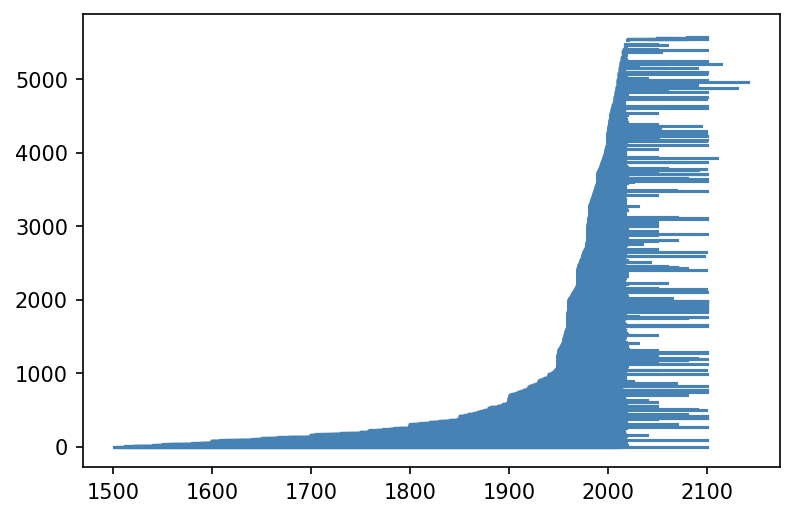

In [202]:
fig, ax = plt.subplots(dpi=150)
its = []
for i,r in df.loc[pd.notna(df['min_year']),].sort_values('min_year').reset_index(drop=True).iterrows():
    #print(r['min_year'])
    if r['min_year'] is not None:
        its = [i,i]
        years = [r['min_year'],r['max_year']]

        ax.plot(years,its,c="steelblue")
        
#ax.set_xticks([10,50,100,150])

In [203]:
for i, r in df.loc[df['min_year'].isin(range(1500,1800)),].head().iterrows():
    print(r['min_year'],r['max_year'])
    print(r['content'])

1782.0 1782.0
Phenotypic variation in the widespread Siberian and Mongolian butterfly species Coenonympha amaryllis (Stoll, 1782), an indicator of undisturbed steppe communities, is analyzed. It is shown that its size variation is influenced by a complex of climatic factors, the most important of them being the average starting date of the frost-free period and average annual temperature in the region. Longitude-dependent variation in size is described by a "sawtooth curve" characteristic of species with changing voltinism.
1643.0 2010.0
A new 368-year tree-ring chronology (A.D. 1643-2010) has been developed in western North Dakota using plains cottonwood (Populus deltoides subsp. monilifera) growing on the relatively undisturbed floodplain of the Little Missouri River in the North Unit of Theodore Roosevelt National Park. We document many slow-growing living trees between 150-370 years old that contradict the common understanding that cottonwoods grow fast and die young. In this north

In [204]:
df = df[pd.notna(df['min_year'])].reset_index(drop=True)
df.head()

,id,content,title,6 - Temperature - lower_pred,6 - Precipitation - lower_pred,min_year,max_year
0,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,1.0,0.0,1958.0,2018.0
1,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",0.0,1.0,2012.0,2012.0
2,2364902,Vegetation growth and productivity may record ...,Responses of Vegetation Productivity to Temper...,1.0,0.0,2003.0,2016.0
3,3313968,Investigation of precipitation characteristics...,Toward coupling hydrological and meteorologica...,0.0,1.0,1984.0,2013.0
4,358394,Recent collection data indicate that at least ...,Characterization of larval habitats of Anophel...,1.0,0.0,2008.0,2010.0


In [205]:
from operator import itemgetter
import ast
places = pd.read_csv('../data/place_df.csv')
places = places[places['country_conf']>0.8]
places = places[pd.notnull(places["geo"])]
def extract_geo(df,l):
    return zip(*[itemgetter(*l)(ast.literal_eval(x.replace("nan",'""'))) for x in places.geo])
places['lat'], places['lon'], places['feature_code'] = extract_geo(places, ["lat","lon","feature_code"])
places = places[places["feature_code"]!="PCLI"]
places.head()


,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code
5,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,31.4706,74.3488,SCHC
14,14,Tibet,"[{'start': 82, 'end': 87}]",CHN,0.833024,"{'admin1': 'Tibet Autonomous Region', 'lat': '...",528848,31.66667,88,ADM1
15,15,Tibetan Plateau,"[{'start': 247, 'end': 262}]",CHN,0.833024,"{'admin1': 'NA', 'lat': '33', 'lon': '92', 'co...",528848,33,92,PLAT
17,17,Tibet,"[{'start': 383, 'end': 388}]",CHN,0.833024,"{'admin1': 'Tibet Autonomous Region', 'lat': '...",528848,31.66667,88,ADM1
19,19,Ganges-Brahmaputra,"[{'start': 52, 'end': 70}]",BGD,0.993103,"{'admin1': 'NA', 'lat': '23', 'lon': '89', 'co...",3298277,23,89,DLTA


In [206]:
df_places = pd.merge(df,places[['word','doc_id','lat','lon']],left_on="id",right_on="doc_id")
print(df_places.shape)
df_places.head()


(7448, 11)


,id,content,title,6 - Temperature - lower_pred,6 - Precipitation - lower_pred,min_year,max_year,word,doc_id,lat,lon
0,422797,1. A number of studies have shown that spring ...,Long-term change in the phenology of spring ph...,1.0,0.0,1955.0,2003.0,Windermere,422797,54.38086,-2.90709
1,515807,Seawater pH and the availability of carbonate ...,Historical baselines and the future of shell c...,1.0,0.0,1960.0,1970.0,California,515807,37.25022,-119.75126
2,498677,There was a synchronous and significant decrea...,Trends in coho marine survival in relation to ...,1.0,0.0,1989.0,1989.0,California,498677,37.25022,-119.75126
3,498677,There was a synchronous and significant decrea...,Trends in coho marine survival in relation to ...,1.0,0.0,1989.0,1989.0,Washington,498677,47.50012,-120.50147
4,498677,There was a synchronous and significant decrea...,Trends in coho marine survival in relation to ...,1.0,0.0,1989.0,1989.0,Pacific,498677,46.55128,-123.77886


In [207]:
df_places.to_csv('../data/places_drivers_prediction.csv',index=False)